In [325]:
import simpy
import random
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import warnings

In [326]:
class FiFoServers:
    def __init__(self, env, mu, num_servers):
        self.mu = mu
        self.server = simpy.Resource(env, capacity=num_servers)
        self.processing_times = []
        self.final_arrival = 1
        self.N = 0
        self.queue_length = 0

class SJFServers:
    def __init__(self, env, mu, num_servers):
        self.mu = mu
        self.server = simpy.PriorityResource(env, capacity=num_servers)
        self.processing_times = []
        self.final_arrival = 1
        self.N = 0
        self.queue_length = 0

def task(name, env, servers, processing_time, waiting_times, print_tasks):

    # A task arrives at the server
    start_time = env.now
    if print_tasks:
        print(f'Task {name} arriving at {start_time}')
    
    servers.final_arrival = start_time
    servers.N += 1
    servers.queue_length += 1

    # Request task to server
    with servers.server.request() as req:

        # Once there is availability at the server, initiate task
        yield req
        end_time = env.now
        servers.queue_length -= 1
  
        if print_tasks:
            print(f'Server starts processing {name} at {end_time}')

        yield env.timeout(processing_time)

        if print_tasks:
            print(f'Server done processing {name} at {env.now}')

        waiting_times.append(end_time - start_time)
        servers.processing_times.append(processing_time)


def get_confidence(data, p=0.95):
    """
    Calculate the mean and confidence interval of a dataset for a given confidence level.

    Parameters:
    - data (array-like): Input data.
    - p (float, optional): Confidence level (default is 0.95).

    Returns:
    tuple: A tuple containing the mean and the confidence interval.
    """

    mean = np.mean(data)
    n = len(data)
    lamb = stats.t.ppf((1 + p) / 2, n - 1)
    sigma = np.std(data)
    confidence = (lamb * sigma / np.sqrt(n))
    return mean, confidence

In [327]:
def task_generator(env, servers, N, lambda_, waiting_times, print_tasks=False):

    # Generate N tasks
    for i in range(N):
        
        # Calculate time at server by Poisson process, not sure if necessary
        processing_time = random.expovariate(servers.mu)

        # Create task
        env.process(task(i, env, servers, processing_time, waiting_times, print_tasks))

        # Calculate time until next task by Poisson process, not sure if necessary
        next_arrival = random.expovariate(lambda_)
        yield env.timeout(next_arrival)

def task_generator_long_tail(env, servers, N, lambda_, waiting_times, print_tasks=False):
    
    # Generate 0.75#N tasks with a processing time of 5*mu
    for i in range(N):

        if i >= N*0.75:
            processing_time = random.expovariate(servers.mu)
        else:
            processing_time = random.expovariate(0.4*servers.mu)
        # Create task
        env.process(task(i, env, servers, processing_time, waiting_times, print_tasks))

        # Calculate time until next task by Poisson process, not sure if necessary
        next_arrival = random.expovariate(lambda_)
        yield env.timeout(next_arrival)

def task_generator_deter(env, servers, N, lambda_, waiting_times, print_tasks=False):
    
    for i in range(N):
        processing_time = 1/servers.mu

        # Create task
        env.process(task(i, env, servers, processing_time, waiting_times, print_tasks))

        # Calculate time until next task by Poisson process, not sure if necessary
        next_arrival = random.expovariate(lambda_)
        yield env.timeout(next_arrival)

In [328]:
def run_simulation(num_servers, mu, lambda_, N, scheduler, print_statistics, mode):
    env = simpy.Environment()

    # Use either First-in First-out or Shortest Job First scheduling
    if scheduler.lower() == 'fifo':
        servers = FiFoServers(env, mu, num_servers)
    elif scheduler.lower() == 'sjf':
        servers = SJFServers(env, mu, num_servers)

    waiting_times = []

    # Generate tasks
    
    if mode == 'deter':
        env.process(task_generator_deter(env, servers, N, lambda_ * num_servers, waiting_times))
        env.run()
    elif mode == 'long tail':
        env.process(task_generator_long_tail(env, servers, N, lambda_ * num_servers, waiting_times))
        env.run()
    elif mode == 'Markov':
        env.process(task_generator(env, servers, N, lambda_ * num_servers, waiting_times))
        env.run()
    
    # Calculate statistics on waiting times
    waiting_times_array = np.array(waiting_times)
    confidence_level = 0.95

    # Calculate confidence interval of waiting time
    mean_waitingtime, confidence_waitingtime = get_confidence(waiting_times_array, confidence_level)

    # Calculate statistics on processing times
    processing_times_array = np.array(servers.processing_times)

    # Calculate confidence interval of processing rate
    mean, confidence = get_confidence(processing_times_array, confidence_level)

    if print_statistics:

        std_waiting_time = np.std(waiting_times_array)
        confidence_interval = (mean_waitingtime - confidence_waitingtime, mean_waitingtime + confidence_waitingtime)

        print(f"{num_servers} server(s):")
        print(f"Average Waiting Time: {mean_waitingtime}")
        print(f"Standard Deviation of Waiting Time: {std_waiting_time}")
        print(f"Confidence Interval (95%): {confidence_interval}\n")
        
        processing_rates_array = 1 / processing_times_array[processing_times_array > 0]
        std_processing_rate = np.std(processing_rates_array)
        confidence_interval = (1 / (mean + confidence), 1 / (mean - confidence))

        print(f"Average Processing Rate of server: {1 / mean}")
        print(f"Standard deviation of Processing Rate {std_processing_rate}")
        print(f"Confidence Interval (95%): {confidence_interval}\n")

        # Print statistics on arrivals
        print(f"Time of final arrival: {servers.final_arrival}")
        print(f"Number of arrivals: {servers.N}")
        print(f"Average arrivals per timestep: {servers.N / servers.final_arrival}\n\n")

    return mean_waitingtime, confidence_waitingtime

In [329]:
def generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n=1):
    """Generates data for the average waiting times with different servers and different system loads."""
    
    ## Ignore division by 0 warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning) 

    data = {}

    # Loop over number of servers
    for num_servers in num_servers_list:
        waitingtimes = []
        confidences = []

        # Loop over different values for rho by varying mu
        for mu in mus:
            waiting_times_for_simulations = []

            # Run simulation multiple times
            for _ in range(n):
                mean_waitingtime, confidence_waitingtime = run_simulation(num_servers, mu, lambda_, N, scheduler, False, mode)
                if n == 1:
                    confidences.append(confidence_waitingtime)
                    waitingtimes.append(mean_waitingtime)
                else:
                    waiting_times_for_simulations.append(mean_waitingtime)

            if n > 1:
                # Calculate mean and confidence interval using the get_confidence function
                mean, confidence = get_confidence(waiting_times_for_simulations)
                waitingtimes.append(mean)
                confidences.append(confidence)

        data[num_servers] = {'x': lambda_ / mus, 'waitingtimes': waitingtimes, 'confidences': confidences}

    return data

def plot_waitingtimes(data, axs):
    """Plots the average waiting times with different servers and different system loads."""
    
    for num_servers, values in data.items():
        x = values['x']
        waitingtimes = values['waitingtimes']
        confidence_waitingtime = np.array(values['confidences'])

        axs.plot(x, waitingtimes, label=f'Number of servers = {num_servers}')
        axs.fill_between(x, waitingtimes - confidence_waitingtime, waitingtimes + confidence_waitingtime, alpha=0.4)

    axs.set_xlabel("System load")
    axs.set_ylabel("Average waiting time")
    axs.legend()

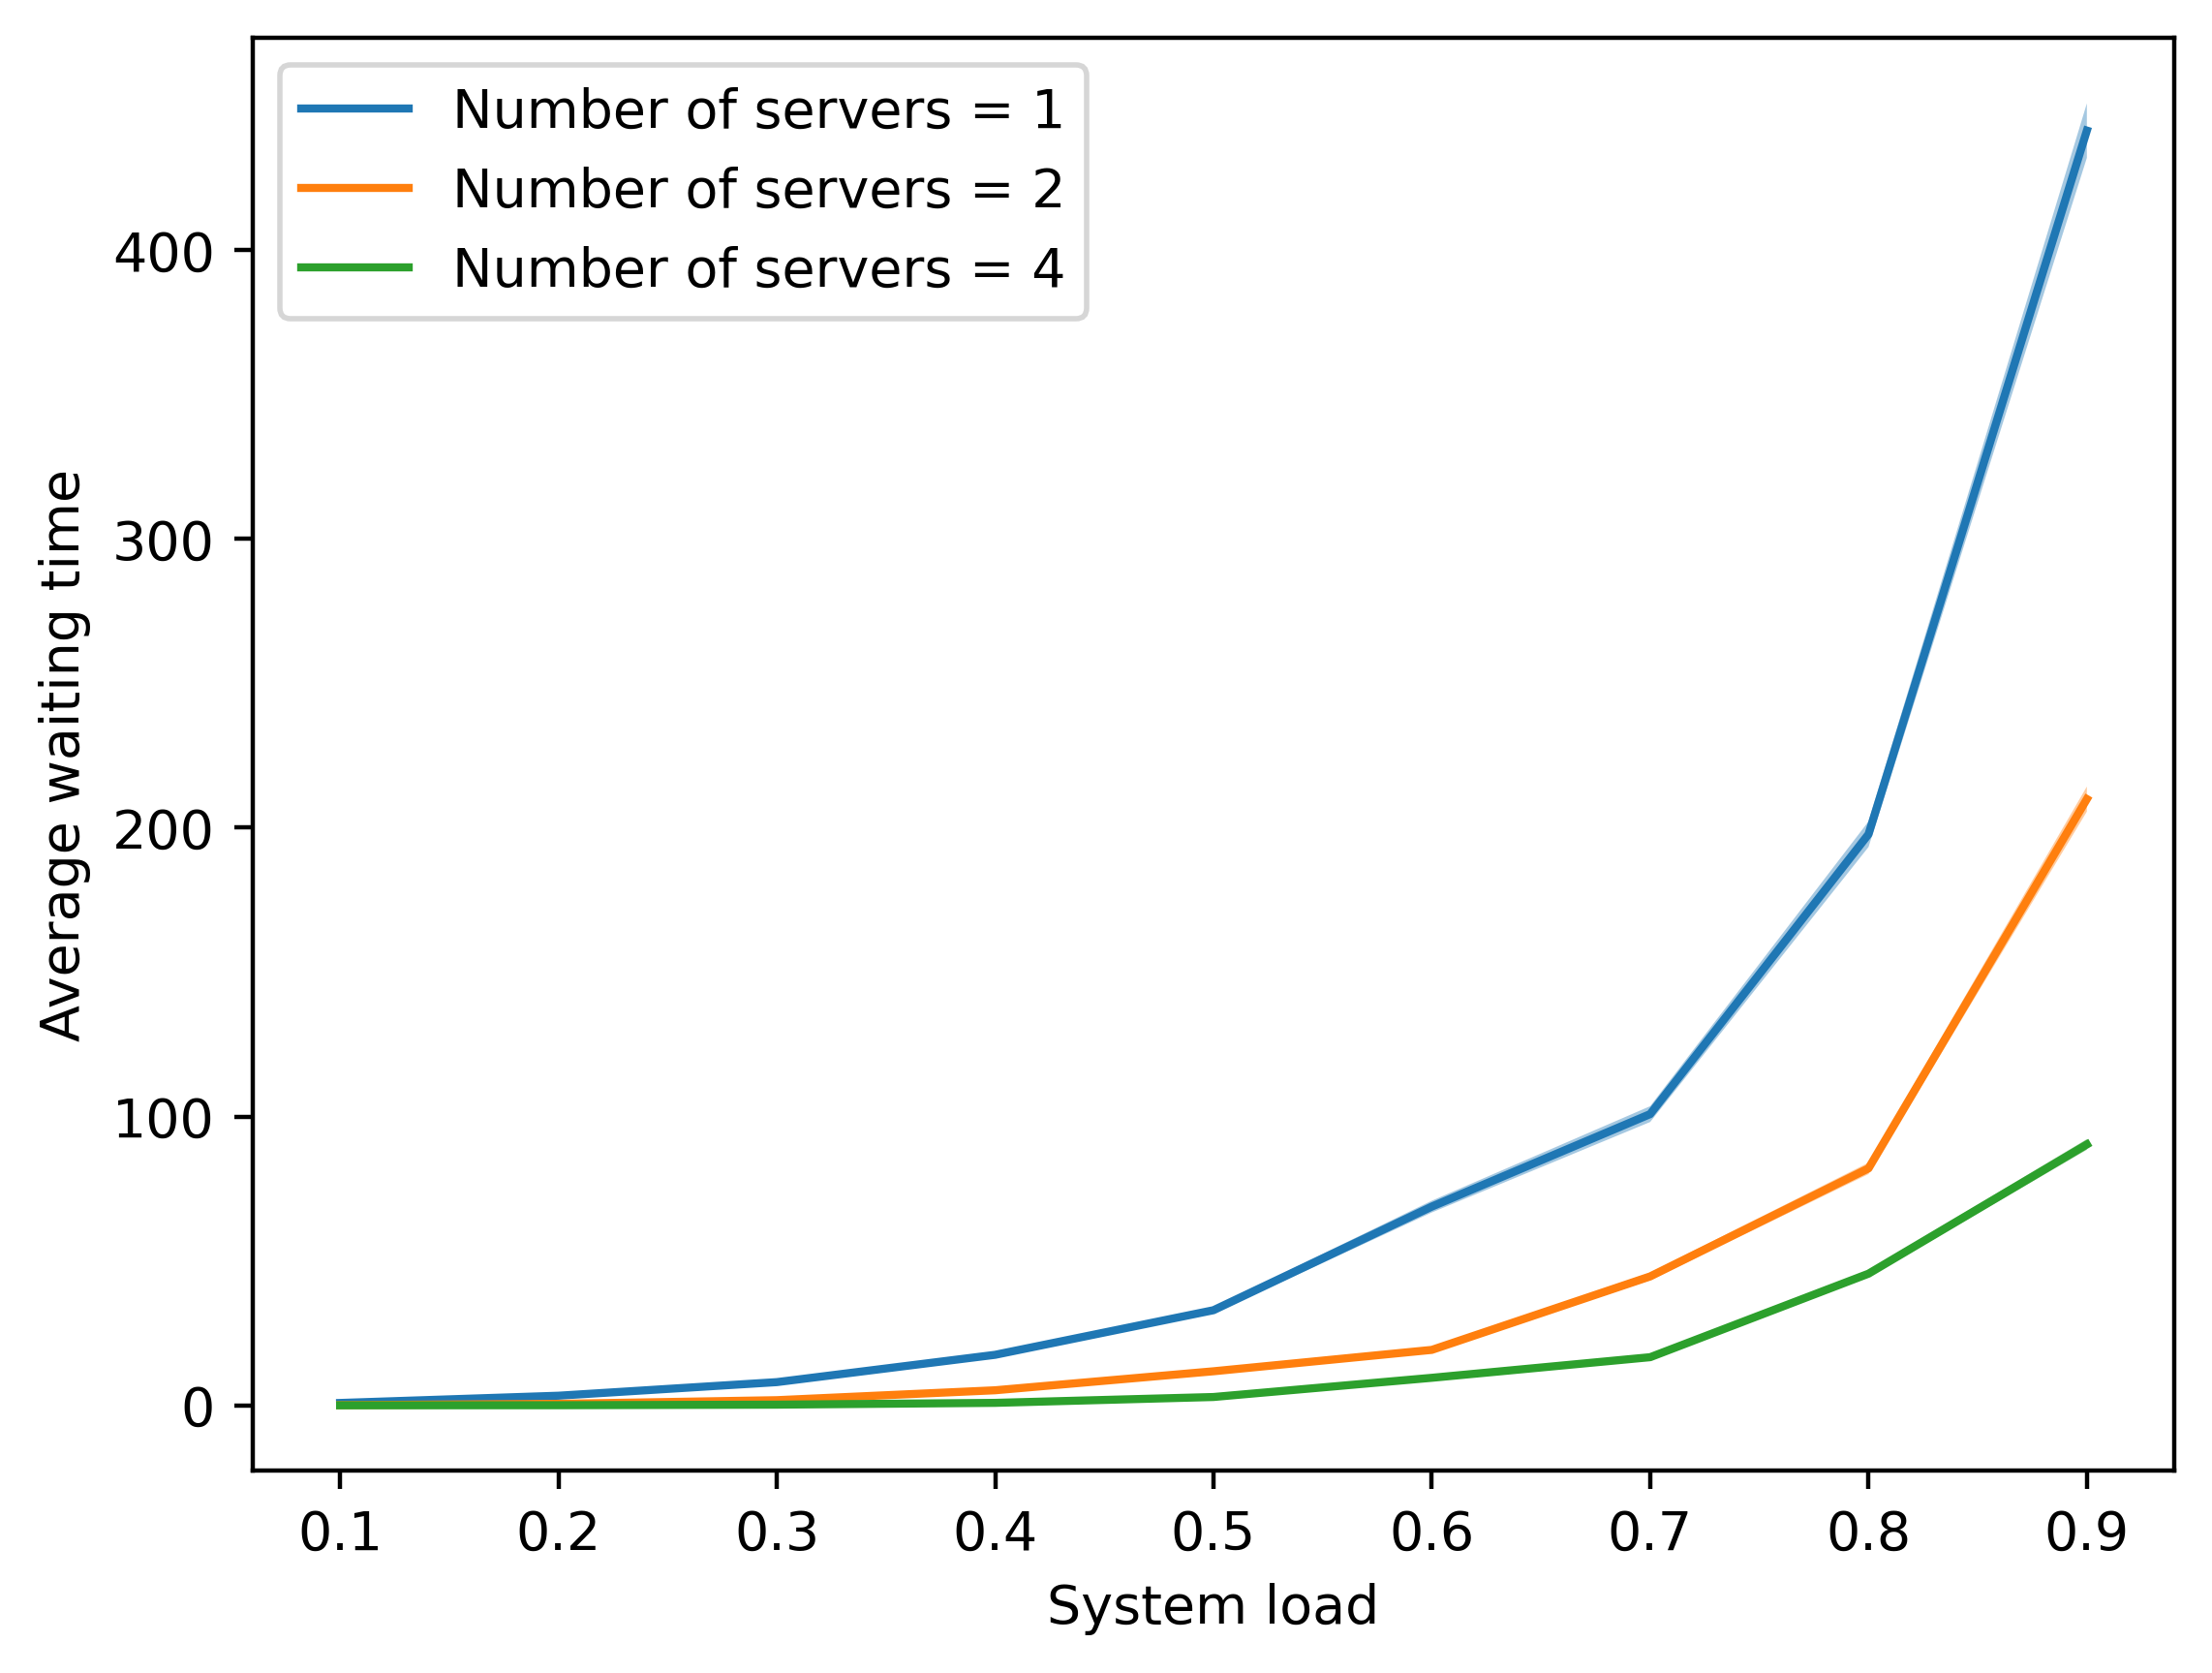

In [330]:
# Parameters
lambda_ = 0.015
N = 10_000
num_servers_list = [1, 2, 4]

# 'fifo' or 'jsf'
scheduler = 'fifo'

# 'Markov', 'deter' or 'long tail'
mode = 'Markov'
print_statistics = False

rho_min, rho_max = 0.1, 0.9
rhos_step = 0.1

rhos = np.arange(rho_min, rho_max + rhos_step, rhos_step)
mus = lambda_ / rhos

# Number of runs. If n = 1, confidence interval is determined by the different waiting times of different tasks
# If n > 1, confidence interval is determined by different average waiting times of those different runs
n = 1

fig, axs = plt.subplots(dpi=400)
data = generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n)

plot_waitingtimes(data, axs)

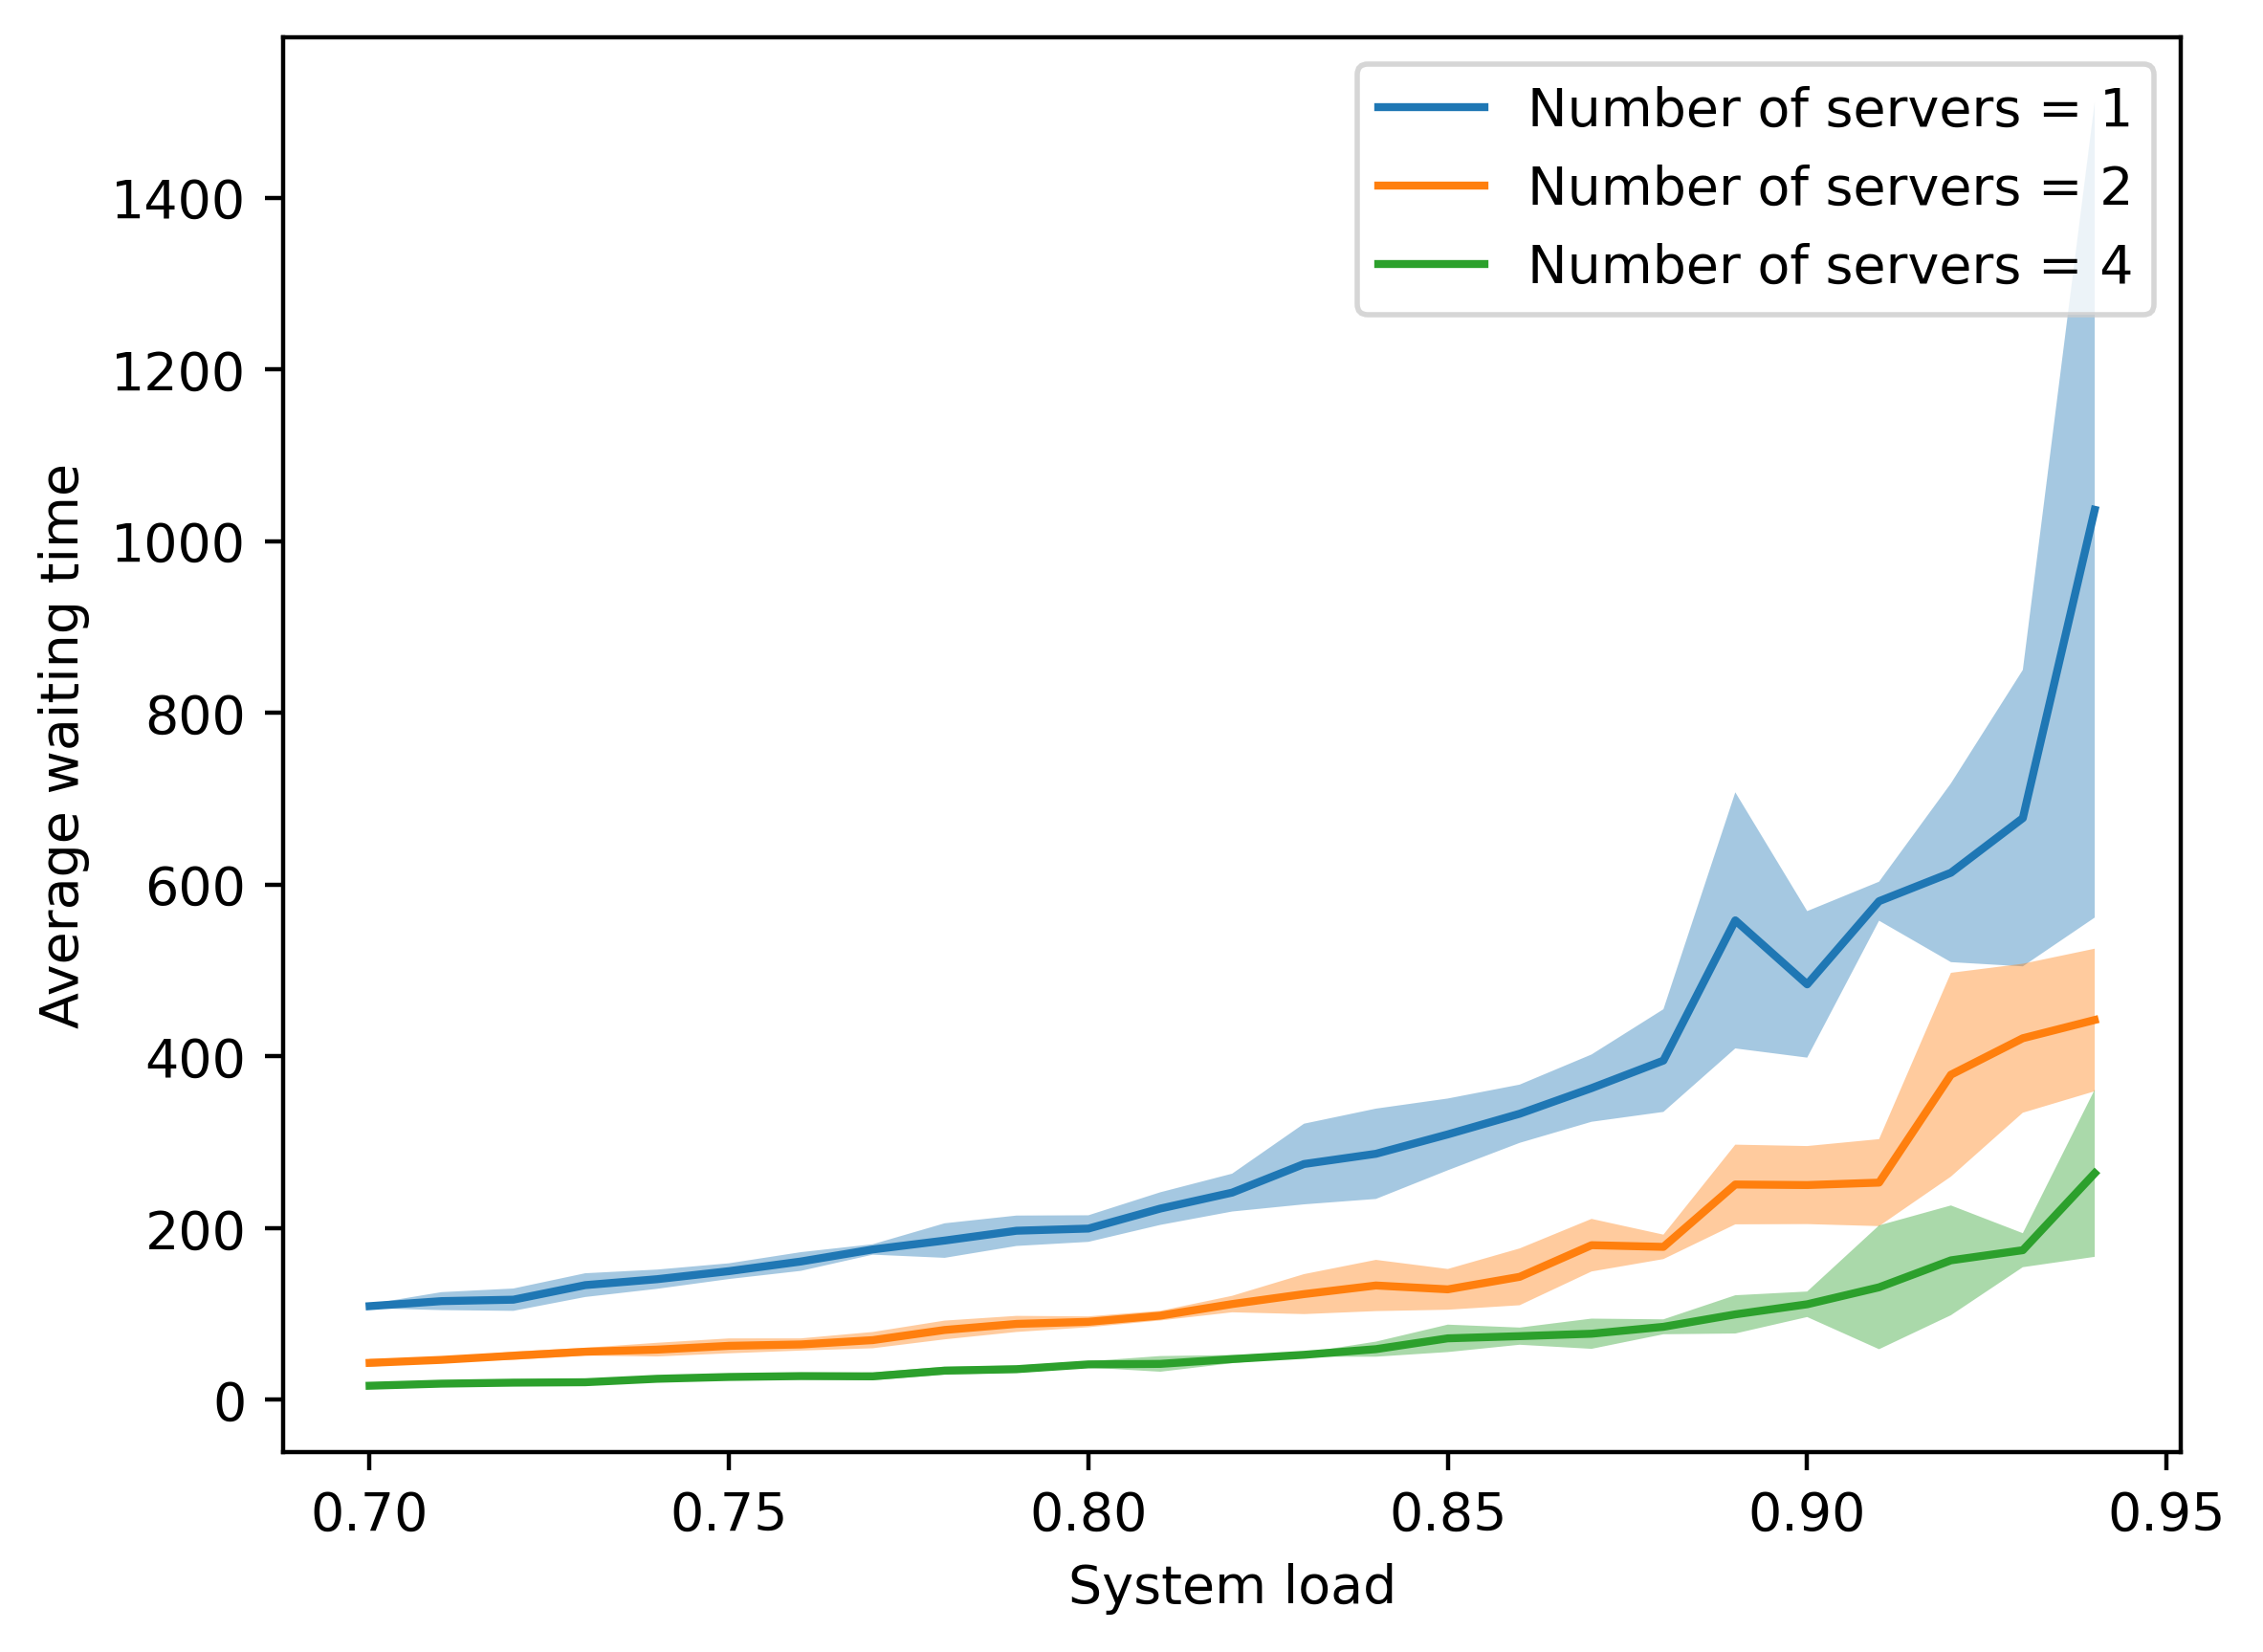

In [331]:
# Parameters
lambda_ = 0.015
N = 10_000
num_servers_list = [1, 2, 4]

# 'fifo' or 'jsf'
scheduler = 'fifo'

# 'Markov', 'deter' or 'long tail'
mode = 'Markov'
print_statistics = False

rho_min, rho_max = 0.7, 0.95
rhos_step = 0.01

rhos = np.arange(rho_min, rho_max, rhos_step)
mus = lambda_ / rhos

# Number of runs. If n = 1, confidence interval is determined by the different waiting times of different tasks
# If n > 1, confidence interval is determined by different average waiting times of those different runs
n = 5

fig, axs = plt.subplots(dpi=400)
data = generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n)

plot_waitingtimes(data, axs)

n way bigger


make a function for combining the different dictionaries, hereby ensure the key names actually make sense

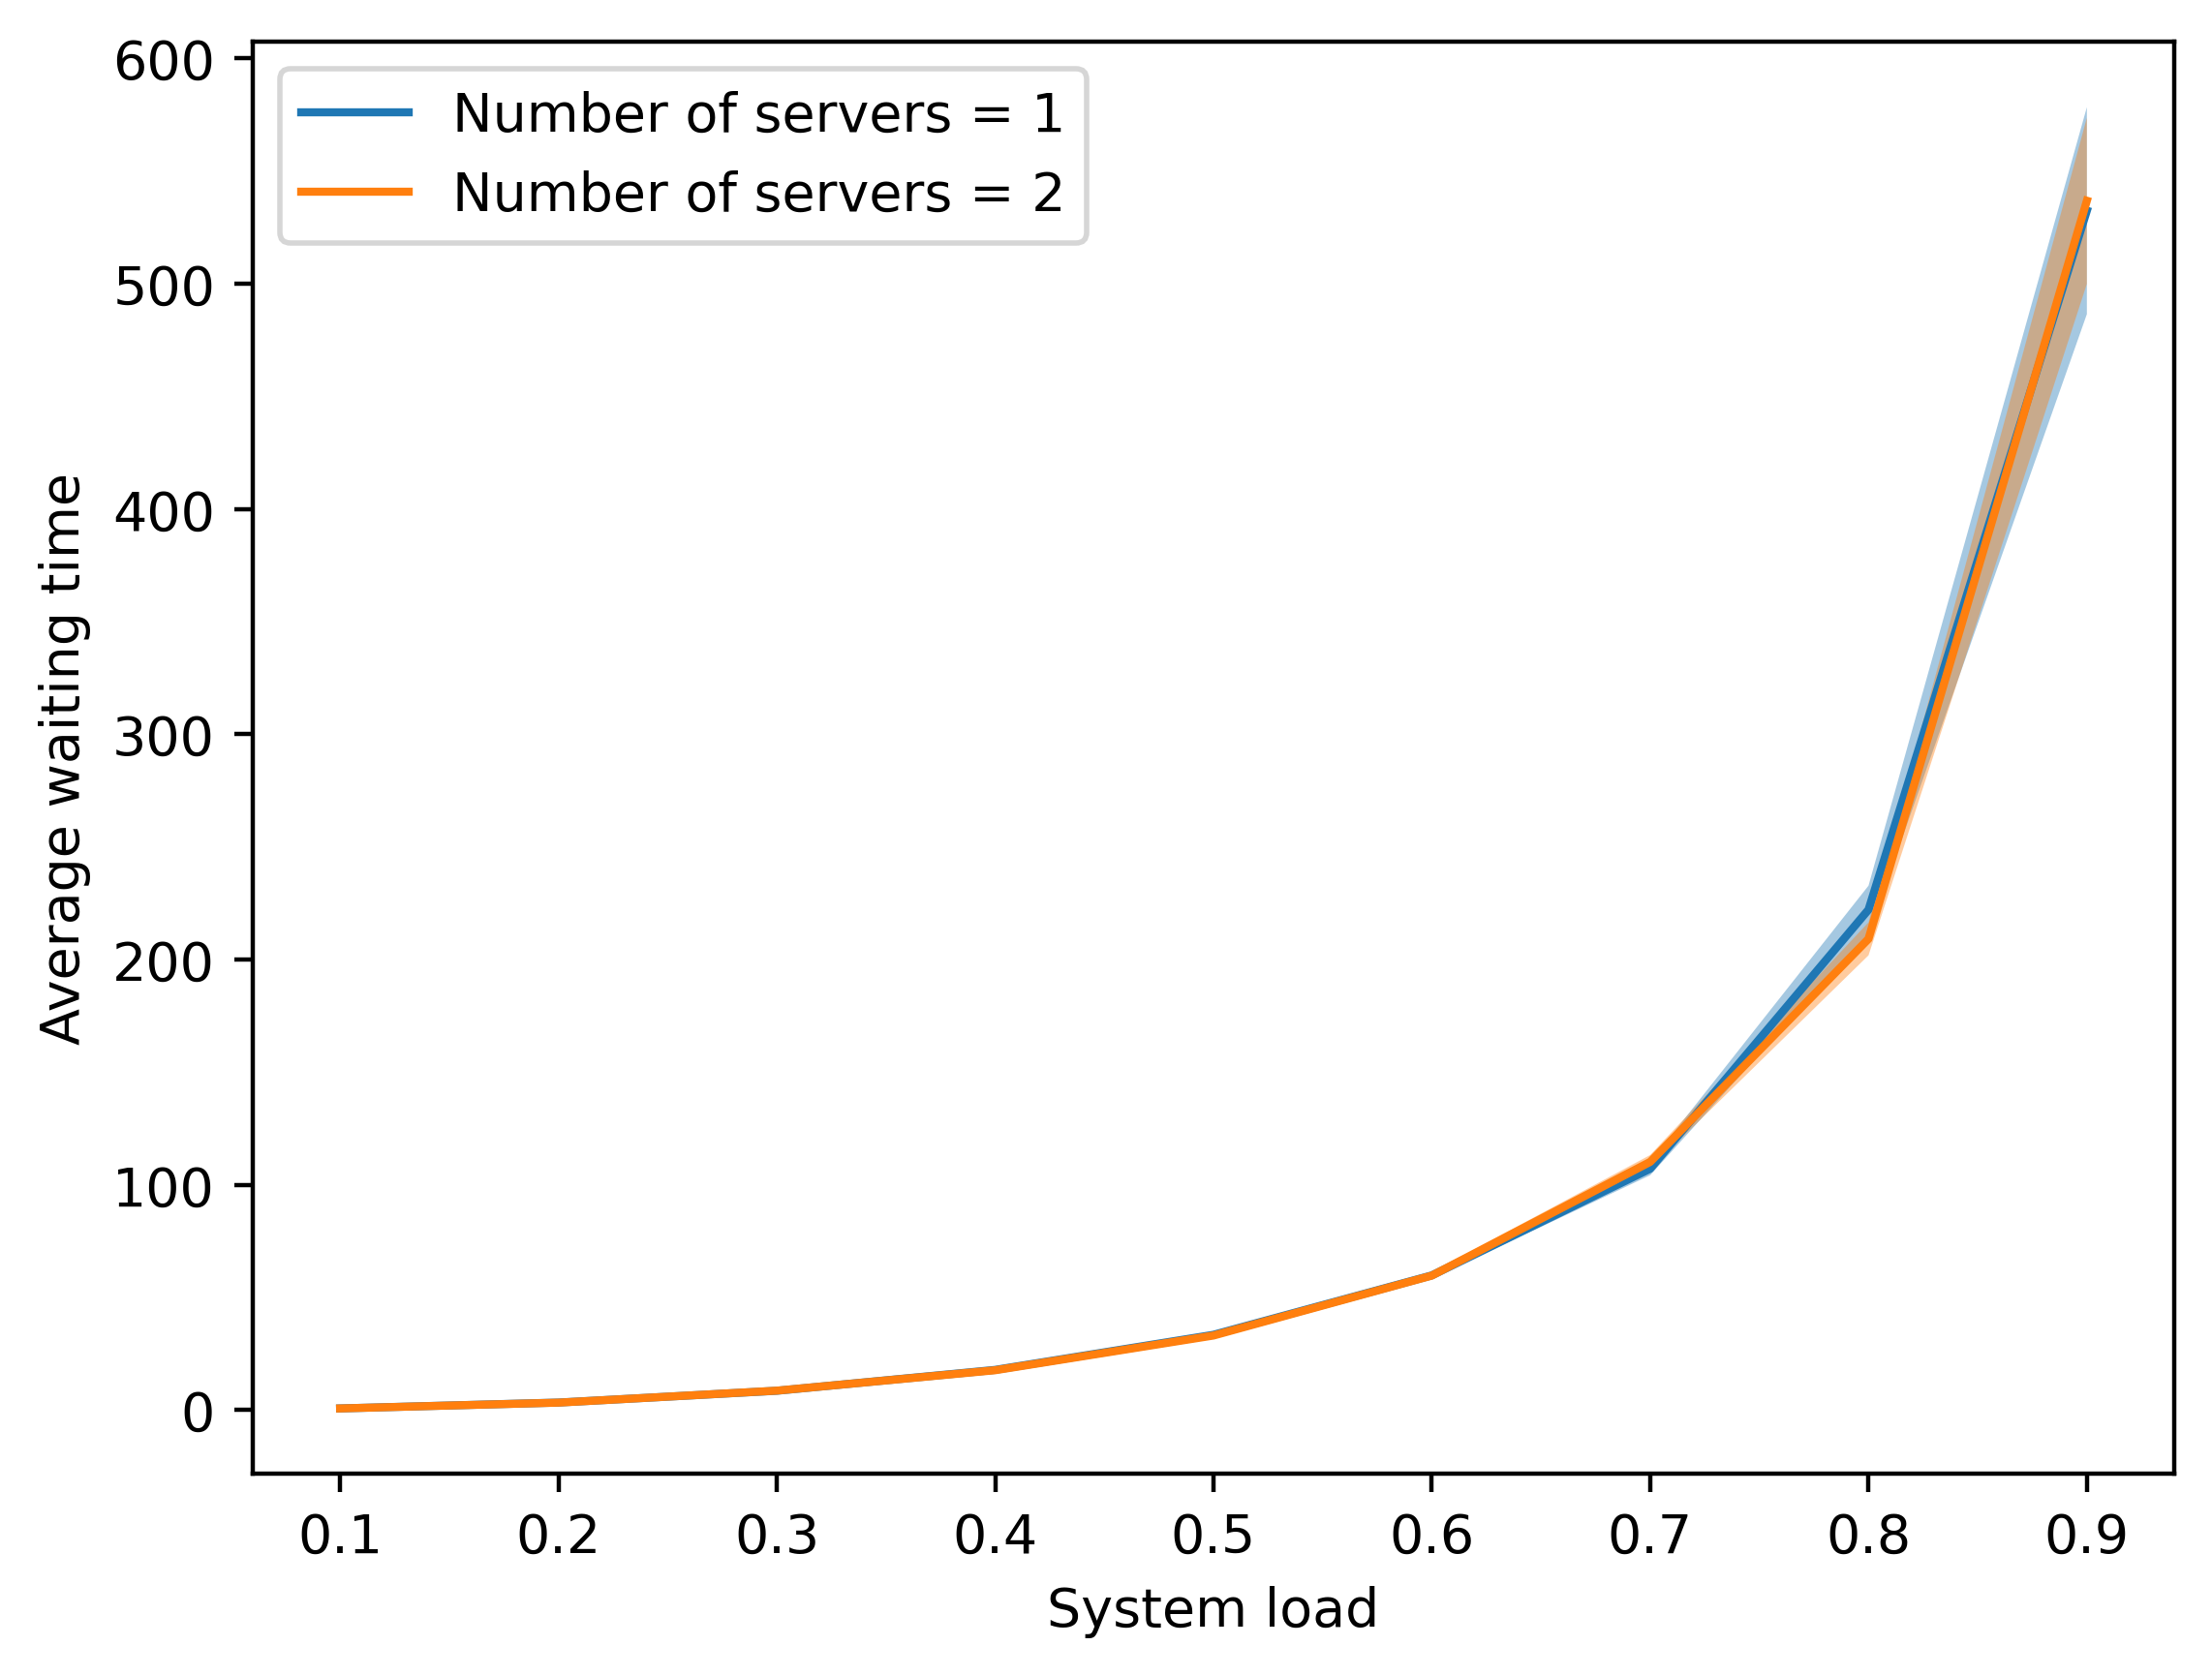

In [335]:
# Parameters
lambda_ = 0.015
N = 10_000
num_servers_list = [1]

# 'fifo' or 'sjf'
scheduler = 'sjf'

# 'Markov', 'deter' or 'long tail'
mode = 'Markov'
print_statistics = False

rho_min, rho_max = 0.1, 0.9
rhos_step = 0.1

rhos = np.arange(rho_min, rho_max + rhos_step, rhos_step)
mus = lambda_ / rhos

# Number of runs. If n = 1, confidence interval is determined by the different waiting times of different tasks
# If n > 1, confidence interval is determined by different average waiting times of those different runs
n = 30

fig, axs = plt.subplots(dpi=400)
data = generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n)

newdata = generate_waitingtimes(lambda_, mus, N, num_servers_list, 'fifo', mode, n)
data[2] = {'x': lambda_ / mus, 'waitingtimes': newdata[1]['waitingtimes'] , 'confidences': newdata[1]['confidences']}

plot_waitingtimes(data, axs)

argue by histogram of processing times

hypothesis test that SJF has shorter average waiting times